# "Covid in Japan"
> "コロナの新規陽性者数のデータを使った時系列データ分析の練習ノート. 日本のコロナの新規陽性者数のデータを使って[統計学基礎 1.7.3節](http://www.tokyo-tosho.co.jp/books/978-4-489-02227-2/)の時系列データの変動分解を試みる. 傾向変動として全国新規陽性者数$y_t$のデータで7日間移動平均を使ったもの, $y_t$の対数を取ったデータに対し7日間移動平均をとったもの,  $y_t$の対数を取ったデータを線形回帰したものを使った変動分解を行い結果を考察する."
- toc: false
- branch: master
- badges: true
- comments: true
- categories: [julia, covid, statistics]
- hide: false
- search_exclude: true

# はじめに

経済時系列データ＄y_t＄の伝統的な分析方法にはデータを次の3種類に分ける方法がある:
$$
y_t=TC_t+S_t+I_t
$$
ここで$TC_t$は傾向変動, $S_t$は季節変動, $I_t$は不規則変動である. $TC_t$は長期的な傾向を表し, $S_t$は１年を周期とするような循環的に繰り返す変動を表し, $I_t$はは上記以外の変動を表す. 

会社の統計勉強会で[統計学基礎](http://www.tokyo-tosho.co.jp/books/978-4-489-02227-2/)を読んでいるがその際にコロナのデータで試そうという話になり, 個人的にも(このような時間の影響をはっきり受ける)時系列データを扱ったことがなかったので練習がてら計算をしてみた. コロナの新規陽性者数の場合では$TC_t$は流行(所謂第$n$波とよばれるもの), $S_t$は曜日別の影響, $I_t$はは上記以外の変動ということになるだろう. コロナの場合には名前がおかしい気がするが気にしないことにする. 


使用している環境は次の通り:

In [1]:
versioninfo()

Julia Version 1.8.4
Commit 00177ebc4fc (2022-12-23 21:32 UTC)
Platform Info:
  OS: macOS (arm64-apple-darwin21.5.0)
  CPU: 8 × Apple M1
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, apple-m1)
  Threads: 1 on 4 virtual cores


# データの準備と可視化

必要なパッケージをロードする:

In [2]:
p=[
"CSV",
"DataFrames",
"Plots",
"Statistics",
"Indicators",
"StatsPlots",
"GLM",
"HTTP",
"Dates"]

9-element Vector{String}:
 "CSV"
 "DataFrames"
 "Plots"
 "Statistics"
 "Indicators"
 "StatsPlots"
 "GLM"
 "HTTP"
 "Dates"

In [3]:
import Pkg; Pkg.add.(p)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Ch

9-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

In [4]:
using CSV
using DataFrames
using Plots
Plots.gr(fmt = :png)
using Statistics
using Indicators
using StatsPlots
using GLM 
using HTTP
using Dates

以上の考え方を試す前にまずは全国新規陽性者数を見てみる. [厚生労働省のオープンデータ](https://www.mhlw.go.jp/stf/covid-19/open-data.html)を利用する. 

In [5]:
res = HTTP.get("https://covid19.mhlw.go.jp/public/opendata/newly_confirmed_cases_daily.csv");

In [6]:
df = CSV.read(res.body,DataFrame);

In [7]:
last(df,10)

Row,Date,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,Gunma,Saitama,Chiba,Tokyo,Kanagawa,Niigata,Toyama,Ishikawa,Fukui,Yamanashi,Nagano,Gifu,Shizuoka,Aichi,Mie,Shiga,Kyoto,Osaka,Hyogo,Nara,Wakayama,Tottori,Shimane,Okayama,Hiroshima,Yamaguchi,Tokushima,Kagawa,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
,String15,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,2022/12/31,107621,2377,808,787,1893,498,653,1343,2825,1586,1343,5287,4318,11190,6891,1406,564,782,701,792,1709,2261,3398,5409,2063,1001,1695,6947,4416,719,1198,656,822,2037,4663,1715,683,1075,1808,716,5346,1338,1271,2183,1854,1698,1959,937
2,2023/1/1,87042,2077,690,651,1715,359,506,1263,2142,1078,1191,3791,3705,9186,5518,1052,448,720,723,890,1378,1780,3310,4547,1771,654,1450,6214,3177,850,988,770,680,1767,3527,1542,433,774,1190,607,3565,807,1081,1446,1129,1614,1534,752
3,2023/1/2,76015,1833,557,624,1450,344,518,1038,1665,1092,1284,3189,3164,7537,5008,937,435,570,571,622,1174,1562,2319,4252,1155,500,1432,4980,2749,665,1101,532,596,1356,3008,1534,444,1095,1190,602,3424,790,1049,1187,1273,1469,1521,618
4,2023/1/3,89643,2235,696,932,1903,440,498,1372,1498,1347,1182,4162,4088,9628,4828,1070,635,827,528,738,1318,2169,2841,4850,1127,1162,1723,6355,2874,858,1155,749,693,1429,2917,1713,482,1021,1725,753,3352,1048,1163,2146,1503,1685,1449,776
5,2023/1/4,104304,2500,730,920,2028,498,753,1607,1660,1495,1609,4991,4035,10554,6567,1527,688,786,801,1069,1493,2281,4311,5829,1461,871,1773,7255,3379,1005,1367,849,764,1848,3698,2072,615,1124,1512,879,4580,1225,1337,1759,1474,1852,1838,1035
6,2023/1/5,226904,5582,1792,2009,3458,1316,1235,3335,1794,3335,4156,10707,10174,20735,10688,2990,1840,2456,1819,1404,3164,5695,6090,13174,1884,3025,3185,15772,7684,2401,1900,1305,1970,4598,3962,5097,2100,3211,5219,1903,13075,3593,3888,6615,3496,4498,5209,2366
7,2023/1/6,245542,5713,1791,1521,3960,1114,1481,3102,5242,3280,3571,11429,9578,20720,11773,3083,1692,2171,1557,2201,3989,4975,8471,15928,4610,2331,4212,15957,12210,2719,2692,1795,1604,5323,8046,3617,2053,2475,3775,1602,14859,2953,3601,5717,3998,4331,4644,2076
8,2023/1/7,238654,5352,1511,1558,3802,957,1224,3005,5138,3280,3373,11330,10180,19630,12840,2962,1338,2177,1232,1762,3202,4888,9475,15774,4579,2741,4267,16704,11490,2394,2450,1681,1565,5332,8091,4006,1726,2593,3573,1456,13963,2664,2955,5269,2886,3946,4147,2186
9,2023/1/8,190538,3363,989,925,3010,666,822,2176,5542,2590,2673,8782,7605,15124,10096,2090,1106,1477,1290,1336,3182,3210,9184,11350,5232,1919,3719,12542,11053,2228,2057,1263,1088,4015,8076,2772,1449,1763,2236,905,11705,1952,2591,3614,2136,2674,3616,1345


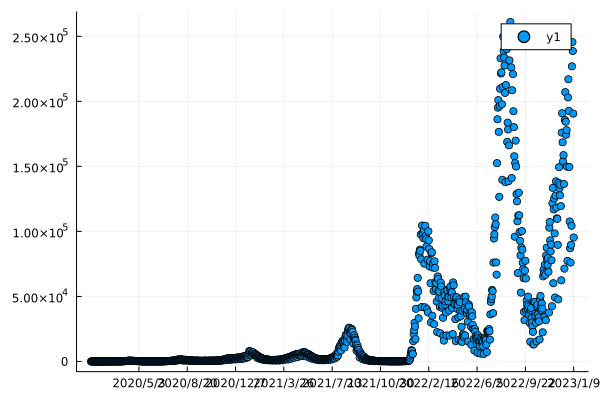

In [8]:
plot(df.Date, df.ALL,seriestype = :scatter)

この図から日本のコロナの流行は過去５回ピークが発生していることが読み取れる. 

## グラフ所感
- 2022/01/04現在では第6波の兆しが見える. 
- 2022/01/11現在では第6波が確定した.

# 傾向変動の計算
## raw dataと7日間移動平均

このデータから$TC_t$を分離したい. まずは教科書に倣い$TC_t$として移動平均を使ってみる. 
日本の検査では休日(日曜)明けの検査では陽性者数が少なく, 木曜に陽性者数が多くでる傾向があることが知られている. そこで7日間の移動平均を取ってみる:

In [9]:
df.weekly_ave=sma(df.ALL, n=7);

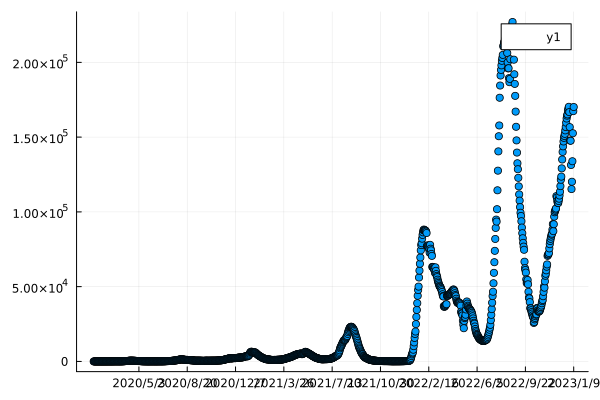

In [10]:
plot(df.Date, df.weekly_ave, seriestype = :scatter)

raw dataから移動平均を引いたものをプロットしてみる:

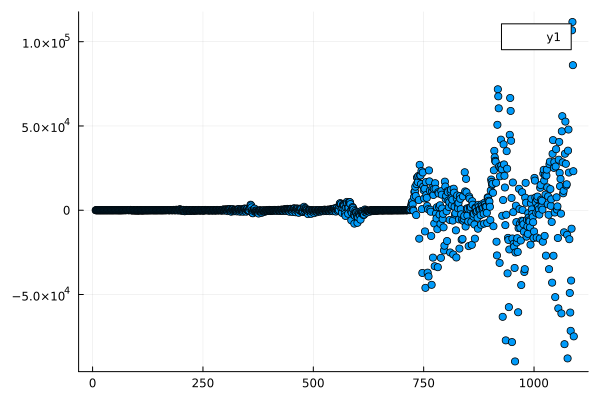

In [11]:
plot(df.ALL .- df.weekly_ave, seriestype = :scatter)

教科書のやり方に倣えば次のステップでは曜日別に平均を取って季節変動を求めるが上記グラフから$TC_t$として移動平均を用いるのは適していない. なぜなら傾向変動$TC_t$は大域的な寄与を表しているはずなのにその影響を除いた$y_t-TC_t$に山の影響が現れているからである. 

## 対数とその7日間移動平均
感染症は指数的に増減することが知られているので対数をとってプロットしてみる. データには新規陽性者数が0の日があり対数をとる際に不便なので微小な数$\epsilon$を加えて回避する. 

In [12]:
ϵ = 0.0000001;

In [13]:
df.log_all=log.(df.ALL .+ ϵ);

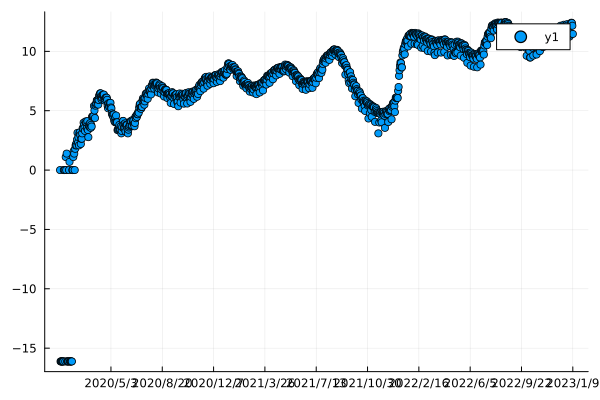

In [14]:
plot(df.Date, df.log_all, seriestype = :scatter)

対数をとってみると第6波の兆候がよりはっきり確認できる. 

対数の世界で移動平均を取り対数化したデータとの差分を見てみる:

In [15]:
df.log_weekly_ave = sma(df.log_all, n=7);
df.log_diff = df.log_all .- df.log_weekly_ave;

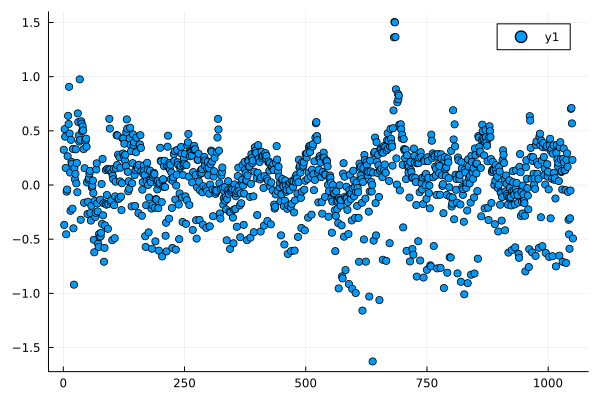

In [16]:
plot((df.log_diff )[40:end], seriestype = :scatter)

対数の世界では移動平均からの差分が大体-1.5~1の間に収まりピークの影響を受けづらくなったことがわかる. ここで最初の39日分は陽性者数が0のデータの影響を受け変動が激しいため捨てた. まだ若干の傾向があるようにも見えるが取り敢えず次に進む. 


次は季節変動$S_t$を計算したい. 上記の図からは曜日別の変動が目視では確認しずらいが曜日別の平均をとって季節変動$S$計算してみる.

In [17]:
sum_n=zeros(7)
count_day_of_week=zeros(Int,7)
for (i, n) in enumerate((df.log_diff )[40:end])
    sum_n[i%7+1]+=n
    count_day_of_week[i%7+1]+=1
 end

In [18]:
S = sum_n ./ count_day_of_week

7-element Vector{Float64}:
 -0.0458947770756838
 -0.48588728064630987
  0.055816830757215156
  0.18126518762346477
  0.1879316238881742
  0.1451808639178051
  0.15539502298303573

In [19]:
Dates.dayname(Date(df.Date[40], dateformat"y/m/d"))

"Monday"

40番目のデータに対応する曜日は月曜日なので$S$の1番目は日曜日に対応する. 

In [20]:
dow=[Dates.dayname(Date(df.Date[40+i], dateformat"y/m/d")) for i=-1:5];

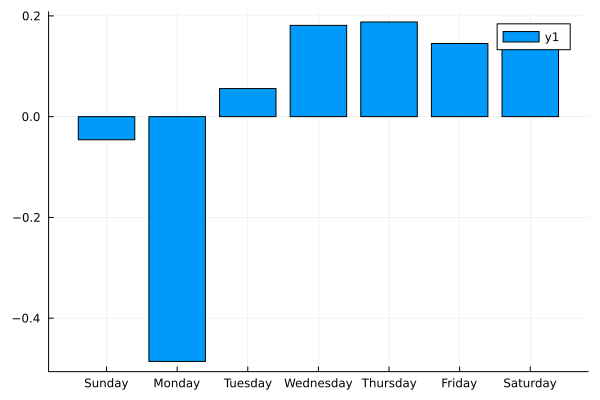

In [21]:
plot(dow,S,seriestype = :bar)

上図からも確かに曜日別の影響として月曜が少なく, 木曜が大きくでる傾向がわかる. 

最後に$I_t$を計算してみる. 

In [22]:
I=zeros(length(df.ALL)-39)
for (i,n) in enumerate((df.log_diff )[40:end])
    I[i]=n-S[i%7+1]
end

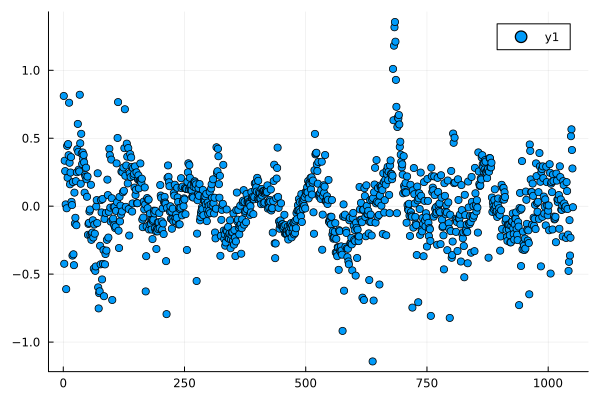

In [23]:
plot(I, seriestype = :scatter)

以上が$TC_t$として移動平均を採用した場合の結果である. $I_t$は流行と曜日の影響を除外したものであることを期待しているが上図からは明らかにそれらが除外できていないことがわかる. 実際山が5つある.

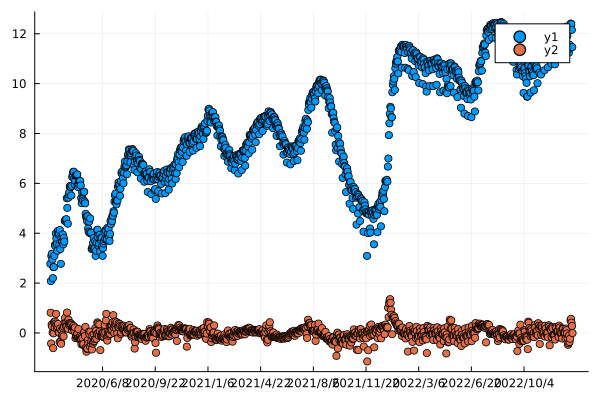

In [24]:
plot(df.Date[40:end], df.log_all[40:end], seriestype = :scatter)
plot!(I, seriestype = :scatter)


$log(y_t)$と$I_t$を並べてみると位相のずれた波と似た挙動をしていることがわかる. すなわちコロナのデータに対し$TC_t$として移動平均は適していない.

## 対数と線形回帰
次は$TC_t$として各流行を線形回帰したものを採用してみる. 

### 区間の計算
まずは流行の区間を計算する. (以下では流行の山と谷を計算しようとしているが上手に計算できなかった. 連続関数なら1階微分が0となる点を求めるが今のデータの場合このアイデアではうまく求めることができなかった. 代わりに全期間から最大の位置を求め, 順に適当な区間で最大最小を交互に計算した. それでも上手に計算できなかったので最後は目視で区間を設定した.)

In [25]:
function minima(array,i,r)
    res=i-r+findmin(array[max(i-r,1):i])[2]
    while res!=i
        i=res
        res=i-r+findmin(array[max(i-r,1):i])[2]
    end
    return res
end

minima (generic function with 1 method)

In [26]:
function maxima(array,i,r)
    res=i-r+findmax(array[max(i-r,1):i])[2]
    while res!=i
        i=res
        res=i-r+findmax(array[max(i-r,1):i])[2]
    end
    return res
end

maxima (generic function with 1 method)

In [27]:
function extremes(array,r)
    i_max=findmax(array)[2]
    res=[i_max]
    i=i_max
    i_min=1
    while i-r>0 && i !=i_min
        i_min=minima(array,i_max,r)
        println(i," ",i_min)
        i_max=maxima(array,i_min,r)
        push!(res,i_min)
        push!(res,i_max)
        i=i_min
    end
    return res
end
    

extremes (generic function with 1 method)

In [28]:
period=extremes(df.ALL, 20)
append!(period,extremes(df.ALL[1:480], 15))
unique!(period)
push!(period,minima(df.ALL,450,10))
append!(period,[30,90,140,680,length(df.ALL)])
sort!(period)

947 888
359 253


12-element Vector{Int64}:
   30
   90
  140
  206
  253
  359
  419
  680
  847
  888
  947
 1090

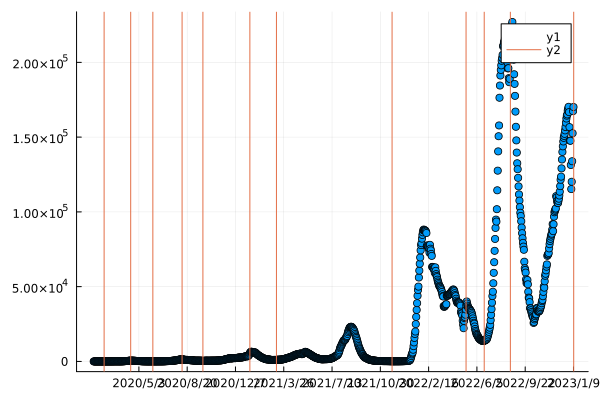

In [29]:
plot(df.Date, df.weekly_ave,seriestype = :scatter)
vline!(period)


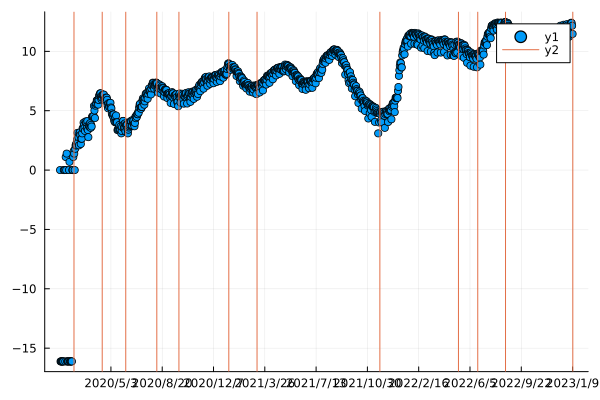

In [30]:
plot(df.Date, df.log_all, seriestype = :scatter)
vline!(period)


### 線形回帰
最初の流行について対数の世界で線形回帰してみる. 回帰には[GLMパッケージ](https://juliastats.org/GLM.jl/v0.11/)を利用する. 

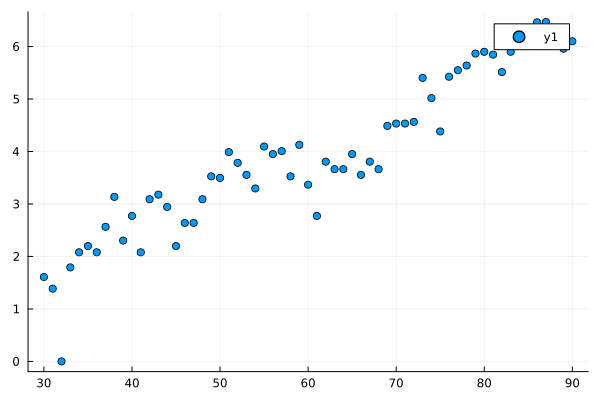

In [31]:
plot(period[1]:period[2],df.log_all[period[1]:period[2]], seriestype = :scatter)

In [32]:
i=1
data = DataFrame(X=period[i]:period[i+1], Y=df.log_all[period[i]:period[i+1]])
ols = lm(@formula(Y ~ X), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      t  Pr(>|t|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  -0.807003   0.22738     -3.55    0.0008  -1.26199    -0.352016
X             0.0789489  0.00363634  21.71    <1e-29   0.0716726   0.0862252
────────────────────────────────────────────────────────────────────────────

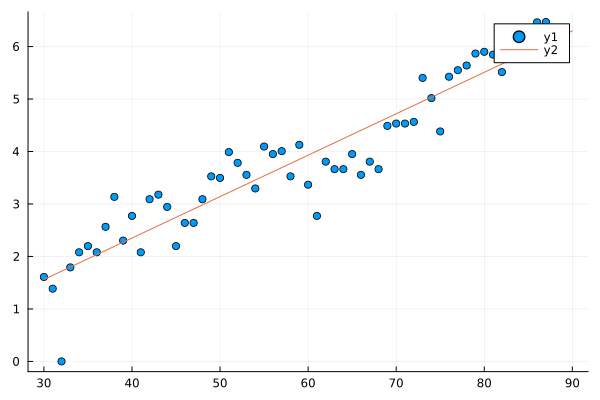

In [33]:
plot(period[i]:period[i+1]-1,df.log_all[period[i]:period[i+1]-1], seriestype = :scatter)
plot!(data.X,predict(ols))

同様に他の区間でも回帰する:

In [34]:
pred=predict(ols)
for i=2:length(period)-1
    data = DataFrame(X=period[i]:period[i+1]-1, Y=df.log_all[period[i]:period[i+1]-1])
    ols = lm(@formula(Y ~ X), data)
    append!(pred,predict(ols))
end

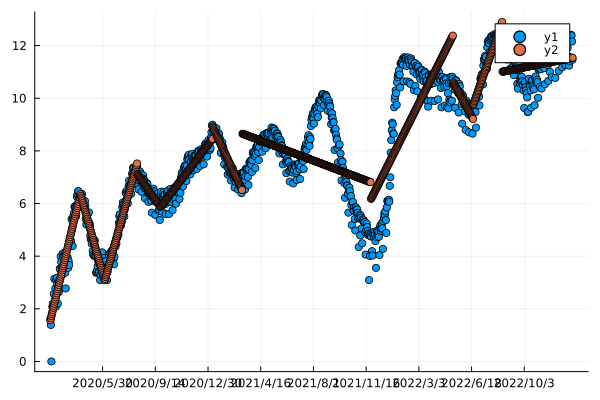

In [35]:
plot(df.Date[period[1]:end], df.log_all[period[1]:end], seriestype = :scatter)
plot!(df.Date[period[1]:end],pred,seriestype = :scatter)

これで各流行で回帰ができた. 

あとはこの回帰を$TC_t$として先ほどと同じ手順で$S_t$, $I_t$を計算してみる. 

In [36]:
diff= df.log_all[period[1]:end] .- pred;

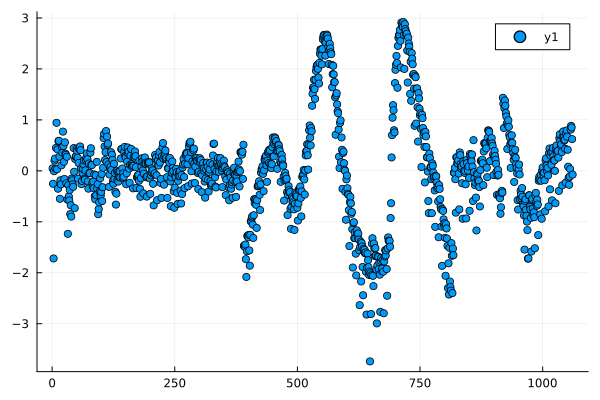

In [37]:
plot(diff, seriestype = :scatter)

In [38]:
sum_n=zeros(7)
count_day_of_week=zeros(Int,7)
for (i, n) in enumerate(diff)
    sum_n[i%7+1]+=n
    count_day_of_week[i%7+1]+=1
 end

In [39]:
S2 = sum_n ./ count_day_of_week

7-element Vector{Float64}:
  0.1597298156141544
  0.1224051792494716
  0.14164292461164305
 -0.07029766752689469
 -0.4973507234395729
  0.03803188451298746
  0.14337600662335104

In [40]:
Dates.dayname(Date(df.Date[period[1]], dateformat"y/m/d"))

"Friday"

In [41]:
dow=[Dates.dayname(Date(df.Date[period[1]+i], dateformat"y/m/d")) for i=-1:5];

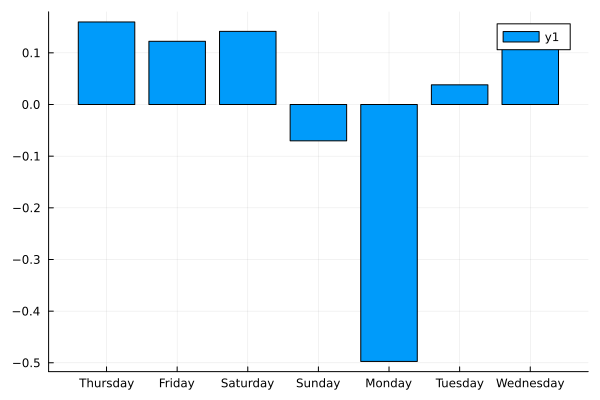

In [42]:
plot(dow,S2,seriestype = :bar)

In [43]:
I2=zeros(length(df.ALL)-period[1]+1)
for (i,n) in enumerate((diff )[period[1]:end])
    I2[i]=n-S2[i%7+1]
end

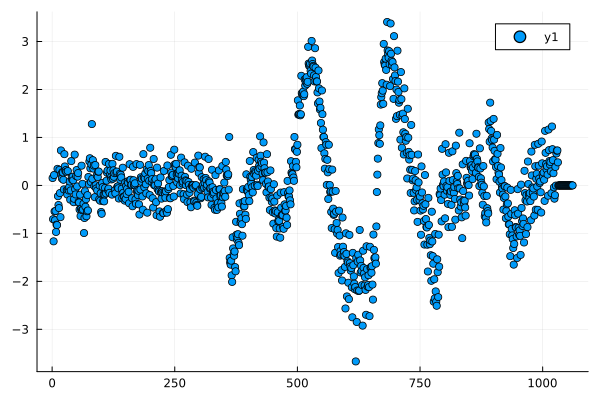

In [44]:
plot(I2, seriestype = :scatter)

個人的な感覚ではこの結果からもまだ傾向のようなもの感じるがを移動平均を使った場合の結果と比べるとかなり改善はされた. コロナの新規陽性者のデータに対し$TC_t$として安直に移動平均を使うのは不適切である.

# まとめ

コロナのデータに対し(1)生データと移動平均, (2)対数とその移動平均, (3)対数とその線形回帰で変動分解を比較した. 